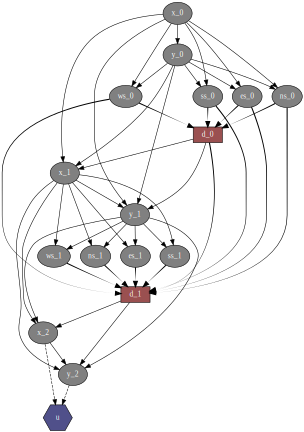

'SIS=bnb.SIS(ID.idFromName("d_0"),ID)\nprint("SIS",SIS)\n#bnb.SIS(ID.idFromName("d_1"))\nfor i in ID.names():\n    if(ID.idFromName(i) in SIS):\n        print("in SIS : ",i,ID.idFromName(i))'

In [5]:
import os
from pylab import *
import matplotlib.pyplot as plt
from IPython.core.display import display,HTML
import math
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import numpy as np
from bandbLIMID import BranchAndBoundLIMIDInference

def createIDRobot(n,xInitial,yInitial,maze):
    
    """
    chances contient tous les identifiants des noeuds chance de l'ID, par convention, si l'ID est égal à
    0 mod(6) --> le noeud est un x
    1 mod(6) --> le noeud est un y
    2 mod(6) --> le noeud est un n
    3 mod(6) --> le noeud est un e
    4 mod(6) --> le noeud est un s
    5 mod(6) --> le noeud est un w

    decision contient tous les identifiants des noeuds décisions de l'ID, par convention, si l'ID est égal à 
    6*n+i pour tout i appartenant à 0,...,n-1, le noeud est le noeud décision de la ième étape.
    """

    """
    Méthode permettant de créer le diagramme d'influence de l'exemple du robot vu dans l'article "2013_Solving_Limited_Memory_Influence_Diagrams_Using_BranchAndBound"

    Entrée : 
    n - nombre de stage
    xInitial - coordonnée x initial où on dépose le robot
    yInitial - coordonnée y initial où on dépose le robot
    Sortie :
    ID - le diagramme d'influence correspondant à la modélisation du problème
    """

    #gris est l'ensemble des coordonnées des cases grises
    cases,gris,caseObj,nbLignes,nbColonnes=getCasesAndGris2(maze)
    #listes qui énumère les cases ou on peut faire un pas dans une certaine direction (càd pas de mur dans cette direction quand on est sur cette case)
    casesOuPossibleAllerGauche=[]
    casesOuPossibleAllerHaut=[]
    casesOuPossibleAllerDroite=[]
    casesOuPossibleAllerBas=[]

    #constructions des listes ci-dessus
    for x in range(nbLignes):
        for y in range(nbColonnes):
            if(cases[x,y,0]==0):
                casesOuPossibleAllerGauche.append([x,y])
            if(cases[x,y,1]==0):
                casesOuPossibleAllerHaut.append([x,y])
            if(cases[x,y,2]==0):
                casesOuPossibleAllerDroite.append([x,y])
            if(cases[x,y,3]==0):
                casesOuPossibleAllerBas.append([x,y])
    #création de l'ID
    ID=gum.fastID("")
    #tous les noeuds chances, regroupés selon leur stages (0 étant celui du premier stage)
    chances=np.zeros((n,6))
    #tous les noeuds décisions, celui à l'indice 0 étant celui du premier stage
    decision=np.zeros(n)
   
    for i in range(n):
        #définition des noms, pour eviter les opérations non necessaires
        x=f"x_{i}"
        y=f"y_{i}"
        ns=f"ns_{i}"
        es=f"es_{i}"
        ss=f"ss_{i}"
        ws=f"ws_{i}"
        d=f"d_{i}"

        #Création des noeuds 
        #ajout noeuds position x
        chances[i][0]=int(ID.addChanceNode(gum.LabelizedVariable(x,"",nbLignes),6*i))
        #ajout noeuds position y
        chances[i][1]=int(ID.addChanceNode(gum.LabelizedVariable(y,"",nbColonnes),6*i+1))
        #ajout noeuds capteurs selon coordonnées cardinales
        chances[i][2]=ID.addChanceNode(gum.LabelizedVariable(ns,"",2),6*i+2)
        chances[i][3]=ID.addChanceNode(gum.LabelizedVariable(es,"",2),6*i+2+1)
        chances[i][4]=ID.addChanceNode(gum.LabelizedVariable(ss,"",2),6*i+2+2)
        chances[i][5]=ID.addChanceNode(gum.LabelizedVariable(ws,"",2),6*i+2+3)
        #ajout noeud de décision
        decision[i]=int(ID.addDecisionNode(gum.LabelizedVariable(d,"",5),i+50000))


        

        #Creation des arcs entre x,y et les capteurs de l'étape courante
        ID.addArc(x,y)
        ID.addArc(x,ns)
        ID.addArc(x,es)
        ID.addArc(x,ss)
        ID.addArc(x,ws)
        ID.addArc(y,ns)
        ID.addArc(y,es)
        ID.addArc(y,ss)
        ID.addArc(y,ws)

        #Création des arcs depuis TOUS les noeuds chances des capteurs vers le noeud de décision courant
        #de l'étape
        for stage in range(i+1):
            ID.addArc(int(chances[(stage)][2]),ID.idFromName(d))
            ID.addArc(int(chances[(stage)][3]),ID.idFromName(d))
            ID.addArc(int(chances[(stage)][4]),ID.idFromName(d))
            ID.addArc(int(chances[(stage)][5]),ID.idFromName(d))
        #Création des arcs depuis x_i-1 vers x_i et de y_i-1 vers y_i (seulement à partir de la deuxième étape)
        if(i>0):
            ID.addArc(f"x_{i-1}",y)
            ID.addArc(f"x_{i-1}",x)
            ID.addArc(f"y_{i-1}",y)
            ID.addArc(f"y_{i-1}",x)
            ID.addArc(f"d_{i-1}",f"d_{i}")

            #Création des arcs entre le noeud de décision de la i-1 ème étape vers x_i et y_i
            ID.addArc(f"d_{i-1}",x)
            ID.addArc(f"d_{i-1}",y)


        #ajout potentiels des noeuds chance capteur ns es ss ws, de support {0=pas mur,1=mur}
        for h in range(nbLignes):
            for j in range(nbColonnes):
                if([h,j] in casesOuPossibleAllerHaut):
                    ID.cpt(ns)[{x:h,y:j}]=[1,0]
                else:
                    ID.cpt(ns)[{x:h,y:j}]=[0,1]
                if([h,j] in casesOuPossibleAllerBas):
                    ID.cpt(ss)[{x:h,y:j}]=[1,0]
                else:
                    ID.cpt(ss)[{x:h,y:j}]=[0,1]
                if([h,j] in casesOuPossibleAllerDroite):
                    ID.cpt(es)[{x:h,y:j}]=[1,0]
                else:
                    ID.cpt(es)[{x:h,y:j}]=[0,1]
                if([h,j] in casesOuPossibleAllerGauche):
                    ID.cpt(ws)[{x:h,y:j}]=[1,0]
                else:
                    ID.cpt(ws)[{x:h,y:j}]=[0,1]
                if [h,j] in gris:
                    ID.cpt(ns)[{x:h,y:j}]=[0,1]
                    ID.cpt(es)[{x:h,y:j}]=[0,1]
                    ID.cpt(ss)[{x:h,y:j}]=[0,1]
                    ID.cpt(ws)[{x:h,y:j}]=[0,1]
        

    #ajout potentiels des noeuds positions x y au premier stage
        if(i==0):
            ID.cpt(x)[xInitial]=1
            ID.cpt(y)[{x:xInitial,y:yInitial}]=1
    #ajout potentiels des noeuds positions x y aux stages qui ne sont pas le premier stage
        else:
            remplirID(ID,x,fillX,i,casesOuPossibleAllerGauche,
    casesOuPossibleAllerHaut,
    casesOuPossibleAllerDroite,
    casesOuPossibleAllerBas,gris)
            remplirID(ID,y,fillY,i,casesOuPossibleAllerGauche,
    casesOuPossibleAllerHaut,
    casesOuPossibleAllerDroite,
    casesOuPossibleAllerBas,gris)

    #Ajout des arcs entre le dernier noeud décision, les derniers noeuds chances x et y avec le noeud utilité
    xn=f"x_{n}"
    yn=f"y_{n}"
    ID.addArc(int(decision[n-1]),ID.addChanceNode(gum.LabelizedVariable(xn,"",nbLignes)))
    ID.addArc(int(decision[n-1]),ID.addChanceNode(gum.LabelizedVariable(yn,"",nbColonnes)))
    ID.addArc(xn,yn)
    ID.addUtilityNode(gum.LabelizedVariable("u","",1))
    ID.addArc(xn,"u")
    ID.addArc(yn,"u")
    ID.addArc(f"x_{n-1}",xn)
    ID.addArc(f"y_{n-1}",xn)
    ID.addArc(f"x_{n-1}",yn)
    ID.addArc(f"y_{n-1}",yn)
    #ajout potentiels des derniers noeuds chances et du noeud d'utilité
    remplirID(ID,xn,fillX,n,casesOuPossibleAllerGauche,
    casesOuPossibleAllerHaut,
    casesOuPossibleAllerDroite,
    casesOuPossibleAllerBas,gris)
    remplirID(ID,yn,fillY,n,casesOuPossibleAllerGauche,
    casesOuPossibleAllerHaut,
    casesOuPossibleAllerDroite,
    casesOuPossibleAllerBas,gris)
    
    ID.utility(ID.idFromName("u"))[{f"x_{n}":caseObj[0],f"y_{n}":caseObj[1]}]=1
    
    return ID


def remplirID(ID,NomNoeud,fonctionFill,stage,casesOuPossibleAllerGauche,

    casesOuPossibleAllerHaut,
    casesOuPossibleAllerDroite,
    casesOuPossibleAllerBas,gris):
    I=gum.Instantiation(ID.cpt(NomNoeud))
    """
    Méthode qui sert à remplir le tableau de potentiel des noeuds positions x et y aux stages après au premier stage
    Entrée : 
        InfluenceDiagram ID - le diagramme d'influence sur lequel trouver tous les noeuds
        String NomNoeud - le nom du noeud qu'on veut remplir le tableau de potentiel 
        function fonctionFill - la fonction utilisée afin de remplir les cases du tableau
        Integer stage - entier qui identifie le stage courant
    Sortie:
        void
    """
    while not I.end():
        ID.cpt(NomNoeud).set(I,fonctionFill(I,stage,casesOuPossibleAllerGauche,
    casesOuPossibleAllerHaut,
    casesOuPossibleAllerDroite,
    casesOuPossibleAllerBas,gris))
        I.inc()

def fillX(I,i,casesOuPossibleAllerGauche,
    casesOuPossibleAllerHaut,
    casesOuPossibleAllerDroite,
    casesOuPossibleAllerBas,gris):
    valeurXStageDavant,valeurYStageDavant,valeurX,decisionDStageDavant=[I.val(nomNoeud) for nomNoeud in [f"x_{i-1}",f"y_{i-1}",f"x_{i}",f"d_{i-1}"]]
    """
    Méthode qui sert à déterminer quelle probabilité on introduit dans la case d'un certain tableau de potentiel d'un noeud chance correspondant à la position X (abscisse) du robot à un certain stage.
    Entrée :
        Instantiation I - correspond à une certaine case du tableau de potentiel qu'on remplit, on fait des tests dessus afin de savoir quelle                           probabilité donner à cette case.
        Integer i - entier correspondant au stage courant.
    """ 
    if([valeurXStageDavant,valeurYStageDavant] in gris):
        return 0
    if(abs(valeurX-valeurXStageDavant)>1):
        return 0
    #-----------------------    
    if(decisionDStageDavant==0): #decision = gauche
        if([valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerGauche):
            if(valeurX==valeurXStageDavant-1):
                return 0.89+0.01
            if(valeurX==valeurXStageDavant):
                return 0.089
            if(valeurX==valeurXStageDavant+1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerDroite): #on teste en plus si on peut aller à droite pour savoir si on peut mettre une proba dessus
                return 0.01
        else:
            if(valeurX==valeurXStageDavant-1): #(je sais que c'est de base à 0 mais je garde pour la compréhension du code)
                return 0
            if(valeurX==valeurXStageDavant):
                return 0.089
            if(valeurX==valeurXStageDavant+1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerDroite):
                return 0.01
    #-----------------------             
    if(decisionDStageDavant==1): #decision = haut
        if([valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerHaut):
            if(valeurX==valeurXStageDavant-1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerGauche):
                return 0.01
            if(valeurX==valeurXStageDavant):
                return 0.89+0.089
            if(valeurX==valeurXStageDavant+1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerDroite):
                return 0.01
        else:
            if(valeurX==valeurXStageDavant-1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerGauche):
                return 0.01
            if(valeurX==valeurXStageDavant): #pas sur sur la proba à mettre 0.89 ou 0.089 ou 0??
                return 0.089
            if(valeurX==valeurXStageDavant+1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerDroite):
                return 0.01
    #-----------------------  
    if(decisionDStageDavant==2): #decision = droite
        if([valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerDroite):
            if(valeurX==valeurXStageDavant-1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerGauche):
                return 0.01
            if(valeurX==valeurXStageDavant):
                return 0.089
            if(valeurX==valeurXStageDavant+1):
                return 0.01+0.89
        else:
            if(valeurX==valeurXStageDavant-1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerGauche):
                return 0.01
            if(valeurX==valeurXStageDavant): #pas sur sur la proba à mettre 0.89 ou 0.089 ou 0??
                return 0.089
            if(valeurX==valeurXStageDavant+1):
                return 0
    #-----------------------  
    if(decisionDStageDavant==3): #decision = bas
        if([valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerBas):
            if(valeurX==valeurXStageDavant-1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerGauche):
                return 0.01
            if(valeurX==valeurXStageDavant):
                return 0.89+0.089
            if(valeurX==valeurXStageDavant+1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerDroite):
                return 0.01
        else:
            if(valeurX==valeurXStageDavant-1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerGauche):
                return 0.01
            if(valeurX==valeurXStageDavant): #pas sur sur la proba à mettre 0.89 ou 0.089 ou 0??
                return 0.089
            if(valeurX==valeurXStageDavant+1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerDroite):
                return 0.01
    #-----------------------  
    if(decisionDStageDavant==4): #decision = rester sur place
        if(valeurX==valeurXStageDavant-1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerGauche):
                return 0.01
        if(valeurX==valeurXStageDavant):
                return 0.89
        if(valeurX==valeurXStageDavant+1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerDroite):
                return 0.01
    return 0





def fillY(I,i,casesOuPossibleAllerGauche,
    casesOuPossibleAllerHaut,
    casesOuPossibleAllerDroite,
    casesOuPossibleAllerBas,gris):
    valeurXStageDavant,valeurYStageDavant,valeurX,valeurY,decisionDStageDavant=[I.val(nomNoeud) for nomNoeud in [f"x_{i-1}",f"y_{i-1}",f"x_{i}",f"y_{i}",f"d_{i-1}"]]
    """
    Méthode qui sert à déterminer quelle probabilité on introduit dans la case d'un certain tableau de potentiel d'un noeud chance correspondant à la position Y (ordonnée) du robot à un certain stage.
    Entrée :
        Instantiation I - correspond à une certaine case du tableau de potentiel qu'on remplit, on fait des tests dessus afin de savoir quelle                           probabilité donner à cette case.
        Integer i - entier correspondant au stage courant.
    """ 
    if([valeurXStageDavant,valeurYStageDavant] in gris):
        return 0
    if(abs(valeurX-valeurXStageDavant)>1 or abs(valeurY-valeurYStageDavant)>1):
        return 0
    #-----------------------  
    if(decisionDStageDavant==0): #decision = gauche
        if([valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerGauche):
            if(valeurX==valeurXStageDavant): #X n'a pas bougé
                if(valeurY==valeurYStageDavant):#Y n'a pas bougé
                    return 0.089
                if(valeurY==valeurYStageDavant+1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerBas):#Y a descendu
                    return 0.001
            if(valeurX==valeurXStageDavant-1): #X a fait un pas à gauche
                if(valeurY==valeurYStageDavant):#Y n'a pas bougé
                    return 0.89
                if(valeurY==valeurYStageDavant+1 and [valeurX,valeurYStageDavant] in casesOuPossibleAllerBas):#Y a descendu (on regarde bien valeurX pas valeurXStageDavant car X a bougé)
                    return 0.001
            if(valeurX==valeurXStageDavant+1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerDroite): #X fait pas à droite
                if(valeurY==valeurYStageDavant):#Y n'a pas bougé
                    return 1-0.001
                if(valeurY==valeurYStageDavant+1 and [valeurX,valeurYStageDavant] in casesOuPossibleAllerBas):#Y a descendu 
                    return 0.001
    #-----------------------  
    if(decisionDStageDavant==1): #decision = haut
        if([valeurX,valeurYStageDavant] in casesOuPossibleAllerHaut): #ON REGARDE DIRECTEMENT VALEURX
            if(valeurY==valeurYStageDavant-1):#Y a bougé en haut
                return 0.89
            if(valeurY==valeurYStageDavant):#Y n'a pas bougé
                return 0.089
            if(valeurY==valeurYStageDavant+1 and [valeurX,valeurYStageDavant] in casesOuPossibleAllerBas):#Y a descendu
                return 0.001
    #-----------------------  
    if(decisionDStageDavant==2): #decision = droit
        if([valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerDroite):
            if(valeurX==valeurXStageDavant): #X n'a pas bougé
                if(valeurY==valeurYStageDavant):#Y n'a pas bougé
                    return 0.089
                if(valeurY==valeurYStageDavant+1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerBas):#Y a descendu
                    return 0.001
            if(valeurX==valeurXStageDavant-1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerGauche): #X fait pas à gauche
                if(valeurY==valeurYStageDavant):#Y n'a pas bougé
                    return 1-0.001
                if(valeurY==valeurYStageDavant+1 and [valeurX,valeurYStageDavant] in casesOuPossibleAllerBas):#Y a descendu (on regarde bien valeurX pas valeurXStageDavant car X a bougé)
                    return 0.001
            if(valeurX==valeurXStageDavant+1 ): #X fait pas à droite
                if(valeurY==valeurYStageDavant):#Y n'a pas bougé
                    return 0.89
                if(valeurY==valeurYStageDavant+1 and [valeurX,valeurYStageDavant] in casesOuPossibleAllerBas):#Y a descendu 
                    return 0.001
    #-----------------------  
    if(decisionDStageDavant==3): #decision = bas
        if([valeurX,valeurYStageDavant] in casesOuPossibleAllerBas):
            if(valeurY==valeurYStageDavant+1):#Y a bougé en bas
                return 0.89
            if(valeurY==valeurYStageDavant):#Y n'a pas bougé
                return 0.089
            if(valeurY==valeurYStageDavant+1 and [valeurX,valeurYStageDavant] in casesOuPossibleAllerBas):#Y a descendu
                return 0.001
    #-----------------------  
    if(decisionDStageDavant==4): #decision = rester sur place
        if(valeurY==valeurYStageDavant+1 and [valeurX,valeurYStageDavant] in casesOuPossibleAllerBas):
            return 0.001
    return 0
def getCasesAndGris2(maze):
    """
    Fonction qui retourne deux tableau :
    gris : tableau de tableau de taille deux qui est l'ensemble des coordonnées des cases grisées
    cases : tableau de 3 dimensions qui stocke, pour chaque direction cardinale, pour chaque case, si on peut faire un pas dans cette 
            direction (c'est à dire qu'il n'y pas de mur) 
            convention : cases[x,y,i]=0 si il n'y a pas de mur dans la direction i quand on est dans la case x,y et cases[x,y,i]=1 sinon. i                appartient à [0,1,2,3] qui correspondent à ouest,nord,est,surd respectivement.
    """
    nbLignes=len(maze)
    nbColonnes=len(maze[0])
    cases=np.zeros((nbLignes,nbColonnes,4)) #cases est qui stocke, selon les directions, si on peut faire le pas dans la direction ou non (0 oui, 1 non)
    gris=[]
    for ligne in range(nbLignes):
        cases[ligne,0,0]=1#quand on est sur la premiere colonne, on ne peut pas aller a gauche
        cases[ligne,nbColonnes-1,2]=1#quand on est sur la deniere colonne, on ne peut pas aller a droite
        for colonne in range(nbColonnes):
            cases[0,colonne,1]=1#quand on est sur la premiere ligne, on ne peut pas monter
            cases[nbLignes-1,colonne,3]=1#quand on est sur la derniere ligne, on ne peut pas descendre
            if(maze[ligne][colonne]=="|" or maze[ligne][colonne]=="-"):
                gris.append([ligne,colonne])
                cases[ligne,colonne,0]=1#si on est dans un mur, on peut aller nulle part
                cases[ligne,colonne,1]=1
                cases[ligne,colonne,2]=1
                cases[ligne,colonne,3]=1
                if colonne>0 :
                    cases[ligne,colonne-1,2]=1 # on regarde à droite (la cases[ligne,colonne-1] est à gauche de maze[ligne][colonne] )
                if ligne<nbLignes-1 :
                    cases[ligne+1,colonne,1]=1 #haut
                if ligne>0 :
                    cases[ligne-1,colonne,3]=1 #bas
                if colonne<nbColonnes-1 :
                    cases[ligne,colonne+1,0]=1 #gauche
            elif maze[ligne][colonne]=="$" :
                caseObj=[ligne,colonne]
    return cases,gris,caseObj,nbLignes,nbColonnes
maze=["---------",
      "--     --",
      "-  - -  -",
      "-- - - --",
      "-  - - $-",
      "--     --",
      "---------"]
nbStage=2
xInitial=3
yInitial=2
ID=createIDRobot(nbStage,xInitial,yInitial,maze)
gnb.showInfluenceDiagram(ID)
ordre=[ID.idFromName("d_0"),ID.idFromName("d_1")]
#ordre=[ID.idFromName("d_1"),ID.idFromName("d_0")]
bnb=BranchAndBoundLIMIDInference(ID,ordre)
"""SIS=bnb.SIS(ID.idFromName("d_0"),ID)
print("SIS",SIS)
#bnb.SIS(ID.idFromName("d_1"))
for i in ID.names():
    if(ID.idFromName(i) in SIS):
        print("in SIS : ",i,ID.idFromName(i))"""

In [2]:
bnb.branchAndBounch()



Init
Init end
début while
--------------while n° 0
début couche
len couche : 256
fin couche
début for couche
fin for couche
début calcul evaluations avec nb de décisionNode: 256
début calcul evaluation de solution
fin calcul evaluation de solution
début calcul evaluation de solution
fin calcul evaluation de solution
début calcul evaluation de solution
fin calcul evaluation de solution
début calcul evaluation de solution
fin calcul evaluation de solution
début calcul evaluation de solution
fin calcul evaluation de solution
début calcul evaluation de solution
fin calcul evaluation de solution
début calcul evaluation de solution
fin calcul evaluation de solution
début calcul evaluation de solution
fin calcul evaluation de solution
début calcul evaluation de solution
fin calcul evaluation de solution
début calcul evaluation de solution
fin calcul evaluation de solution
début calcul evaluation de solution
fin calcul evaluation de solution
début calcul evaluation de solution
fin calcul evalu

KeyboardInterrupt: 

In [2]:
ordre=[ID.idFromName("d_0"),ID.idFromName("d_1")]
bnb=BranchAndBoundLIMIDInference(ID,ordre)
relaxedID=bnb.createRelaxation()
gnb.showInfluenceDiagram(relaxedID)


4
5.1 u: 24476 z:  17711
6.1
5.1 u: 17711 z:  6765
6.2
4
5.1 u: 24476 z:  46368
6.1
5.1 u: 46368 z:  6765
6.2
7.3  u= 6765
7.3  u= 6765
4
5.1 u: 24476 z:  6
6.1
5.1 u: 6 z:  6765
6.2
4
5.1 u: 24476 z:  7
6.1
5.1 u: 7 z:  6765
6.2
4
5.1 u: 24476 z:  10
6.1
5.1 u: 10 z:  5
6.1
5.1 u: 5 z:  0
6.1
5.1 u: 0 z:  6765
6.2
4
5.1 u: 24476 z:  8
6.1
5.1 u: 8 z:  3
6.1
5.1 u: 3 z:  1
6.1
5.1 u: 1 z:  6765
6.2
7.2  u= 7
7.2  u= 10
7.2  u= 6
7.2  u= 8


InvalidDirectedCycle: [pyAgrum] Directed cycle detected: Add a directed cycle in a dag !

In [9]:
[1,2,3]==[2,1,3]

False

<pyAgrum.pyAgrum.DAG; proxy of <Swig Object of type 'gum::DAG *' at 0x121939240> >

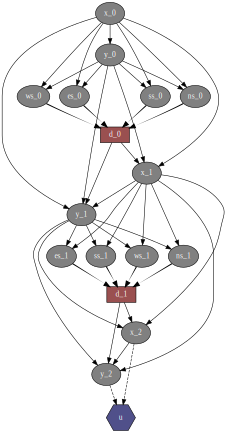

'SIS=bnb.SIS(ID.idFromName("d_0"),ID)\nprint("SIS",SIS)\n#bnb.SIS(ID.idFromName("d_1"))\nfor i in ID.names():\n    if(ID.idFromName(i) in SIS):\n        print("in SIS : ",i,ID.idFromName(i))'

In [1]:
import os
from pylab import *
import matplotlib.pyplot as plt
from IPython.core.display import display,HTML
import math
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import numpy as np
from bandbLIMID import BranchAndBoundLIMIDInference

def createIDRobot(n,xInitial,yInitial,maze):
    
    """
    chances contient tous les identifiants des noeuds chance de l'ID, par convention, si l'ID est égal à
    0 mod(6) --> le noeud est un x
    1 mod(6) --> le noeud est un y
    2 mod(6) --> le noeud est un n
    3 mod(6) --> le noeud est un e
    4 mod(6) --> le noeud est un s
    5 mod(6) --> le noeud est un w

    decision contient tous les identifiants des noeuds décisions de l'ID, par convention, si l'ID est égal à 
    6*n+i pour tout i appartenant à 0,...,n-1, le noeud est le noeud décision de la ième étape.
    """

    """
    Méthode permettant de créer le diagramme d'influence de l'exemple du robot vu dans l'article "2013_Solving_Limited_Memory_Influence_Diagrams_Using_BranchAndBound"

    Entrée : 
    n - nombre de stage
    xInitial - coordonnée x initial où on dépose le robot
    yInitial - coordonnée y initial où on dépose le robot
    Sortie :
    ID - le diagramme d'influence correspondant à la modélisation du problème
    """

    #gris est l'ensemble des coordonnées des cases grises
    cases,gris,caseObj,nbLignes,nbColonnes=getCasesAndGris2(maze)
    #listes qui énumère les cases ou on peut faire un pas dans une certaine direction (càd pas de mur dans cette direction quand on est sur cette case)
    casesOuPossibleAllerGauche=[]
    casesOuPossibleAllerHaut=[]
    casesOuPossibleAllerDroite=[]
    casesOuPossibleAllerBas=[]

    #constructions des listes ci-dessus
    for x in range(nbLignes):
        for y in range(nbColonnes):
            if(cases[x,y,0]==0):
                casesOuPossibleAllerGauche.append([x,y])
            if(cases[x,y,1]==0):
                casesOuPossibleAllerHaut.append([x,y])
            if(cases[x,y,2]==0):
                casesOuPossibleAllerDroite.append([x,y])
            if(cases[x,y,3]==0):
                casesOuPossibleAllerBas.append([x,y])
    #création de l'ID
    ID=gum.fastID("")
    #tous les noeuds chances, regroupés selon leur stages (0 étant celui du premier stage)
    chances=np.zeros((n,6))
    #tous les noeuds décisions, celui à l'indice 0 étant celui du premier stage
    decision=np.zeros(n)
   
    for i in range(n):
        #définition des noms, pour eviter les opérations non necessaires
        x=f"x_{i}"
        y=f"y_{i}"
        ns=f"ns_{i}"
        es=f"es_{i}"
        ss=f"ss_{i}"
        ws=f"ws_{i}"
        d=f"d_{i}"

        #Création des noeuds 
        #ajout noeuds position x
        chances[i][0]=int(ID.addChanceNode(gum.LabelizedVariable(x,"",nbLignes),6*i))
        #ajout noeuds position y
        chances[i][1]=int(ID.addChanceNode(gum.LabelizedVariable(y,"",nbColonnes),6*i+1))
        #ajout noeuds capteurs selon coordonnées cardinales
        chances[i][2]=ID.addChanceNode(gum.LabelizedVariable(ns,"",2),6*i+2)
        chances[i][3]=ID.addChanceNode(gum.LabelizedVariable(es,"",2),6*i+2+1)
        chances[i][4]=ID.addChanceNode(gum.LabelizedVariable(ss,"",2),6*i+2+2)
        chances[i][5]=ID.addChanceNode(gum.LabelizedVariable(ws,"",2),6*i+2+3)
        #ajout noeud de décision
        decision[i]=int(ID.addDecisionNode(gum.LabelizedVariable(d,"",5),i+50000))


        

        #Creation des arcs entre x,y et les capteurs de l'étape courante
        ID.addArc(x,y)
        ID.addArc(x,ns)
        ID.addArc(x,es)
        ID.addArc(x,ss)
        ID.addArc(x,ws)
        ID.addArc(y,ns)
        ID.addArc(y,es)
        ID.addArc(y,ss)
        ID.addArc(y,ws)

        #Création des arcs depuis TOUS les noeuds chances des capteurs vers le noeud de décision courant
        #de l'étape
        stage=i
        ID.addArc(int(chances[(stage)][2]),ID.idFromName(d))
        ID.addArc(int(chances[(stage)][3]),ID.idFromName(d))
        ID.addArc(int(chances[(stage)][4]),ID.idFromName(d))
        ID.addArc(int(chances[(stage)][5]),ID.idFromName(d))
        #Création des arcs depuis x_i-1 vers x_i et de y_i-1 vers y_i (seulement à partir de la deuxième étape)
        if(i>0):
            ID.addArc(f"x_{i-1}",y)
            ID.addArc(f"x_{i-1}",x)
            ID.addArc(f"y_{i-1}",y)
            ID.addArc(f"y_{i-1}",x)
            #ID.addArc(f"d_{i-1}",f"d_{i}")

            #Création des arcs entre le noeud de décision de la i-1 ème étape vers x_i et y_i
            ID.addArc(f"d_{i-1}",x)
            ID.addArc(f"d_{i-1}",y)


        #ajout potentiels des noeuds chance capteur ns es ss ws, de support {0=pas mur,1=mur}
        for h in range(nbLignes):
            for j in range(nbColonnes):
                if([h,j] in casesOuPossibleAllerHaut):
                    ID.cpt(ns)[{x:h,y:j}]=[1,0]
                else:
                    ID.cpt(ns)[{x:h,y:j}]=[0,1]
                if([h,j] in casesOuPossibleAllerBas):
                    ID.cpt(ss)[{x:h,y:j}]=[1,0]
                else:
                    ID.cpt(ss)[{x:h,y:j}]=[0,1]
                if([h,j] in casesOuPossibleAllerDroite):
                    ID.cpt(es)[{x:h,y:j}]=[1,0]
                else:
                    ID.cpt(es)[{x:h,y:j}]=[0,1]
                if([h,j] in casesOuPossibleAllerGauche):
                    ID.cpt(ws)[{x:h,y:j}]=[1,0]
                else:
                    ID.cpt(ws)[{x:h,y:j}]=[0,1]
                if [h,j] in gris:
                    ID.cpt(ns)[{x:h,y:j}]=[0,1]
                    ID.cpt(es)[{x:h,y:j}]=[0,1]
                    ID.cpt(ss)[{x:h,y:j}]=[0,1]
                    ID.cpt(ws)[{x:h,y:j}]=[0,1]
        

    #ajout potentiels des noeuds positions x y au premier stage
        if(i==0):
            ID.cpt(x)[xInitial]=1
            ID.cpt(y)[{x:xInitial,y:yInitial}]=1
    #ajout potentiels des noeuds positions x y aux stages qui ne sont pas le premier stage
        else:
            remplirID(ID,x,fillX,i,casesOuPossibleAllerGauche,
    casesOuPossibleAllerHaut,
    casesOuPossibleAllerDroite,
    casesOuPossibleAllerBas,gris)
            remplirID(ID,y,fillY,i,casesOuPossibleAllerGauche,
    casesOuPossibleAllerHaut,
    casesOuPossibleAllerDroite,
    casesOuPossibleAllerBas,gris)

    #Ajout des arcs entre le dernier noeud décision, les derniers noeuds chances x et y avec le noeud utilité
    xn=f"x_{n}"
    yn=f"y_{n}"
    ID.addArc(int(decision[n-1]),ID.addChanceNode(gum.LabelizedVariable(xn,"",nbLignes)))
    ID.addArc(int(decision[n-1]),ID.addChanceNode(gum.LabelizedVariable(yn,"",nbColonnes)))
    ID.addArc(xn,yn)
    ID.addUtilityNode(gum.LabelizedVariable("u","",1))
    ID.addArc(xn,"u")
    ID.addArc(yn,"u")
    ID.addArc(f"x_{n-1}",xn)
    ID.addArc(f"y_{n-1}",xn)
    ID.addArc(f"x_{n-1}",yn)
    ID.addArc(f"y_{n-1}",yn)
    #ajout potentiels des derniers noeuds chances et du noeud d'utilité
    remplirID(ID,xn,fillX,n,casesOuPossibleAllerGauche,
    casesOuPossibleAllerHaut,
    casesOuPossibleAllerDroite,
    casesOuPossibleAllerBas,gris)
    remplirID(ID,yn,fillY,n,casesOuPossibleAllerGauche,
    casesOuPossibleAllerHaut,
    casesOuPossibleAllerDroite,
    casesOuPossibleAllerBas,gris)
    
    ID.utility(ID.idFromName("u"))[{f"x_{n}":caseObj[0],f"y_{n}":caseObj[1]}]=1
    
    return ID


def remplirID(ID,NomNoeud,fonctionFill,stage,casesOuPossibleAllerGauche,

    casesOuPossibleAllerHaut,
    casesOuPossibleAllerDroite,
    casesOuPossibleAllerBas,gris):
    I=gum.Instantiation(ID.cpt(NomNoeud))
    """
    Méthode qui sert à remplir le tableau de potentiel des noeuds positions x et y aux stages après au premier stage
    Entrée : 
        InfluenceDiagram ID - le diagramme d'influence sur lequel trouver tous les noeuds
        String NomNoeud - le nom du noeud qu'on veut remplir le tableau de potentiel 
        function fonctionFill - la fonction utilisée afin de remplir les cases du tableau
        Integer stage - entier qui identifie le stage courant
    Sortie:
        void
    """
    while not I.end():
        ID.cpt(NomNoeud).set(I,fonctionFill(I,stage,casesOuPossibleAllerGauche,
    casesOuPossibleAllerHaut,
    casesOuPossibleAllerDroite,
    casesOuPossibleAllerBas,gris))
        I.inc()

def fillX(I,i,casesOuPossibleAllerGauche,
    casesOuPossibleAllerHaut,
    casesOuPossibleAllerDroite,
    casesOuPossibleAllerBas,gris):
    valeurXStageDavant,valeurYStageDavant,valeurX,decisionDStageDavant=[I.val(nomNoeud) for nomNoeud in [f"x_{i-1}",f"y_{i-1}",f"x_{i}",f"d_{i-1}"]]
    """
    Méthode qui sert à déterminer quelle probabilité on introduit dans la case d'un certain tableau de potentiel d'un noeud chance correspondant à la position X (abscisse) du robot à un certain stage.
    Entrée :
        Instantiation I - correspond à une certaine case du tableau de potentiel qu'on remplit, on fait des tests dessus afin de savoir quelle                           probabilité donner à cette case.
        Integer i - entier correspondant au stage courant.
    """ 
    if([valeurXStageDavant,valeurYStageDavant] in gris):
        return 0
    if(abs(valeurX-valeurXStageDavant)>1):
        return 0
    #-----------------------    
    if(decisionDStageDavant==0): #decision = gauche
        if([valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerGauche):
            if(valeurX==valeurXStageDavant-1):
                return 0.89+0.01
            if(valeurX==valeurXStageDavant):
                return 0.089
            if(valeurX==valeurXStageDavant+1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerDroite): #on teste en plus si on peut aller à droite pour savoir si on peut mettre une proba dessus
                return 0.01
        else:
            if(valeurX==valeurXStageDavant-1): #(je sais que c'est de base à 0 mais je garde pour la compréhension du code)
                return 0
            if(valeurX==valeurXStageDavant):
                return 0.089
            if(valeurX==valeurXStageDavant+1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerDroite):
                return 0.01
    #-----------------------             
    if(decisionDStageDavant==1): #decision = haut
        if([valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerHaut):
            if(valeurX==valeurXStageDavant-1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerGauche):
                return 0.01
            if(valeurX==valeurXStageDavant):
                return 0.89+0.089
            if(valeurX==valeurXStageDavant+1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerDroite):
                return 0.01
        else:
            if(valeurX==valeurXStageDavant-1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerGauche):
                return 0.01
            if(valeurX==valeurXStageDavant): #pas sur sur la proba à mettre 0.89 ou 0.089 ou 0??
                return 0.089
            if(valeurX==valeurXStageDavant+1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerDroite):
                return 0.01
    #-----------------------  
    if(decisionDStageDavant==2): #decision = droite
        if([valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerDroite):
            if(valeurX==valeurXStageDavant-1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerGauche):
                return 0.01
            if(valeurX==valeurXStageDavant):
                return 0.089
            if(valeurX==valeurXStageDavant+1):
                return 0.01+0.89
        else:
            if(valeurX==valeurXStageDavant-1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerGauche):
                return 0.01
            if(valeurX==valeurXStageDavant): #pas sur sur la proba à mettre 0.89 ou 0.089 ou 0??
                return 0.089
            if(valeurX==valeurXStageDavant+1):
                return 0
    #-----------------------  
    if(decisionDStageDavant==3): #decision = bas
        if([valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerBas):
            if(valeurX==valeurXStageDavant-1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerGauche):
                return 0.01
            if(valeurX==valeurXStageDavant):
                return 0.89+0.089
            if(valeurX==valeurXStageDavant+1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerDroite):
                return 0.01
        else:
            if(valeurX==valeurXStageDavant-1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerGauche):
                return 0.01
            if(valeurX==valeurXStageDavant): #pas sur sur la proba à mettre 0.89 ou 0.089 ou 0??
                return 0.089
            if(valeurX==valeurXStageDavant+1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerDroite):
                return 0.01
    #-----------------------  
    if(decisionDStageDavant==4): #decision = rester sur place
        if(valeurX==valeurXStageDavant-1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerGauche):
                return 0.01
        if(valeurX==valeurXStageDavant):
                return 0.89
        if(valeurX==valeurXStageDavant+1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerDroite):
                return 0.01
    return 0





def fillY(I,i,casesOuPossibleAllerGauche,
    casesOuPossibleAllerHaut,
    casesOuPossibleAllerDroite,
    casesOuPossibleAllerBas,gris):
    valeurXStageDavant,valeurYStageDavant,valeurX,valeurY,decisionDStageDavant=[I.val(nomNoeud) for nomNoeud in [f"x_{i-1}",f"y_{i-1}",f"x_{i}",f"y_{i}",f"d_{i-1}"]]
    """
    Méthode qui sert à déterminer quelle probabilité on introduit dans la case d'un certain tableau de potentiel d'un noeud chance correspondant à la position Y (ordonnée) du robot à un certain stage.
    Entrée :
        Instantiation I - correspond à une certaine case du tableau de potentiel qu'on remplit, on fait des tests dessus afin de savoir quelle                           probabilité donner à cette case.
        Integer i - entier correspondant au stage courant.
    """ 
    if([valeurXStageDavant,valeurYStageDavant] in gris):
        return 0
    if(abs(valeurX-valeurXStageDavant)>1 or abs(valeurY-valeurYStageDavant)>1):
        return 0
    #-----------------------  
    if(decisionDStageDavant==0): #decision = gauche
        if([valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerGauche):
            if(valeurX==valeurXStageDavant): #X n'a pas bougé
                if(valeurY==valeurYStageDavant):#Y n'a pas bougé
                    return 0.089
                if(valeurY==valeurYStageDavant+1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerBas):#Y a descendu
                    return 0.001
            if(valeurX==valeurXStageDavant-1): #X a fait un pas à gauche
                if(valeurY==valeurYStageDavant):#Y n'a pas bougé
                    return 0.89
                if(valeurY==valeurYStageDavant+1 and [valeurX,valeurYStageDavant] in casesOuPossibleAllerBas):#Y a descendu (on regarde bien valeurX pas valeurXStageDavant car X a bougé)
                    return 0.001
            if(valeurX==valeurXStageDavant+1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerDroite): #X fait pas à droite
                if(valeurY==valeurYStageDavant):#Y n'a pas bougé
                    return 1-0.001
                if(valeurY==valeurYStageDavant+1 and [valeurX,valeurYStageDavant] in casesOuPossibleAllerBas):#Y a descendu 
                    return 0.001
    #-----------------------  
    if(decisionDStageDavant==1): #decision = haut
        if([valeurX,valeurYStageDavant] in casesOuPossibleAllerHaut): #ON REGARDE DIRECTEMENT VALEURX
            if(valeurY==valeurYStageDavant-1):#Y a bougé en haut
                return 0.89
            if(valeurY==valeurYStageDavant):#Y n'a pas bougé
                return 0.089
            if(valeurY==valeurYStageDavant+1 and [valeurX,valeurYStageDavant] in casesOuPossibleAllerBas):#Y a descendu
                return 0.001
    #-----------------------  
    if(decisionDStageDavant==2): #decision = droit
        if([valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerDroite):
            if(valeurX==valeurXStageDavant): #X n'a pas bougé
                if(valeurY==valeurYStageDavant):#Y n'a pas bougé
                    return 0.089
                if(valeurY==valeurYStageDavant+1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerBas):#Y a descendu
                    return 0.001
            if(valeurX==valeurXStageDavant-1 and [valeurXStageDavant,valeurYStageDavant] in casesOuPossibleAllerGauche): #X fait pas à gauche
                if(valeurY==valeurYStageDavant):#Y n'a pas bougé
                    return 1-0.001
                if(valeurY==valeurYStageDavant+1 and [valeurX,valeurYStageDavant] in casesOuPossibleAllerBas):#Y a descendu (on regarde bien valeurX pas valeurXStageDavant car X a bougé)
                    return 0.001
            if(valeurX==valeurXStageDavant+1 ): #X fait pas à droite
                if(valeurY==valeurYStageDavant):#Y n'a pas bougé
                    return 0.89
                if(valeurY==valeurYStageDavant+1 and [valeurX,valeurYStageDavant] in casesOuPossibleAllerBas):#Y a descendu 
                    return 0.001
    #-----------------------  
    if(decisionDStageDavant==3): #decision = bas
        if([valeurX,valeurYStageDavant] in casesOuPossibleAllerBas):
            if(valeurY==valeurYStageDavant+1):#Y a bougé en bas
                return 0.89
            if(valeurY==valeurYStageDavant):#Y n'a pas bougé
                return 0.089
            if(valeurY==valeurYStageDavant+1 and [valeurX,valeurYStageDavant] in casesOuPossibleAllerBas):#Y a descendu
                return 0.001
    #-----------------------  
    if(decisionDStageDavant==4): #decision = rester sur place
        if(valeurY==valeurYStageDavant+1 and [valeurX,valeurYStageDavant] in casesOuPossibleAllerBas):
            return 0.001
    return 0
def getCasesAndGris2(maze):
    """
    Fonction qui retourne deux tableau :
    gris : tableau de tableau de taille deux qui est l'ensemble des coordonnées des cases grisées
    cases : tableau de 3 dimensions qui stocke, pour chaque direction cardinale, pour chaque case, si on peut faire un pas dans cette 
            direction (c'est à dire qu'il n'y pas de mur) 
            convention : cases[x,y,i]=0 si il n'y a pas de mur dans la direction i quand on est dans la case x,y et cases[x,y,i]=1 sinon. i                appartient à [0,1,2,3] qui correspondent à ouest,nord,est,surd respectivement.
    """
    nbLignes=len(maze)
    nbColonnes=len(maze[0])
    cases=np.zeros((nbLignes,nbColonnes,4)) #cases est qui stocke, selon les directions, si on peut faire le pas dans la direction ou non (0 oui, 1 non)
    gris=[]
    for ligne in range(nbLignes):
        cases[ligne,0,0]=1#quand on est sur la premiere colonne, on ne peut pas aller a gauche
        cases[ligne,nbColonnes-1,2]=1#quand on est sur la deniere colonne, on ne peut pas aller a droite
        for colonne in range(nbColonnes):
            cases[0,colonne,1]=1#quand on est sur la premiere ligne, on ne peut pas monter
            cases[nbLignes-1,colonne,3]=1#quand on est sur la derniere ligne, on ne peut pas descendre
            if(maze[ligne][colonne]=="|" or maze[ligne][colonne]=="-"):
                gris.append([ligne,colonne])
                cases[ligne,colonne,0]=1#si on est dans un mur, on peut aller nulle part
                cases[ligne,colonne,1]=1
                cases[ligne,colonne,2]=1
                cases[ligne,colonne,3]=1
                if colonne>0 :
                    cases[ligne,colonne-1,2]=1 # on regarde à droite (la cases[ligne,colonne-1] est à gauche de maze[ligne][colonne] )
                if ligne<nbLignes-1 :
                    cases[ligne+1,colonne,1]=1 #haut
                if ligne>0 :
                    cases[ligne-1,colonne,3]=1 #bas
                if colonne<nbColonnes-1 :
                    cases[ligne,colonne+1,0]=1 #gauche
            elif maze[ligne][colonne]=="$" :
                caseObj=[ligne,colonne]
    return cases,gris,caseObj,nbLignes,nbColonnes
maze=["---------",
      "--     --",
      "-  - -  -",
      "-- - - --",
      "-  - - $-",
      "--     --",
      "---------"]
nbStage=2
xInitial=3
yInitial=2
ID=createIDRobot(nbStage,xInitial,yInitial,maze)
gnb.showInfluenceDiagram(ID)
ordre=[ID.idFromName("d_0"),ID.idFromName("d_1")]
#ordre=[ID.idFromName("d_1"),ID.idFromName("d_0")]
bnb=BranchAndBoundLIMIDInference(ID,ordre)
"""SIS=bnb.SIS(ID.idFromName("d_0"),ID)
print("SIS",SIS)
#bnb.SIS(ID.idFromName("d_1"))
for i in ID.names():
    if(ID.idFromName(i) in SIS):
        print("in SIS : ",i,ID.idFromName(i))"""

In [2]:
#gnb.showInfluenceDiagram(bnb.IDRelaxe)
d,m=bnb.branchAndBound()



{2: 0, 3: 0, 4: 0, 5: 0} ----
{2: 1, 3: 0, 4: 0, 5: 0} ----
{2: 0, 3: 1, 4: 0, 5: 0} ----
{2: 1, 3: 1, 4: 0, 5: 0} ----
{2: 0, 3: 0, 4: 1, 5: 0} ----
{2: 1, 3: 0, 4: 1, 5: 0} ----
{2: 0, 3: 1, 4: 1, 5: 0} ----
{2: 1, 3: 1, 4: 1, 5: 0} ----
{2: 0, 3: 0, 4: 0, 5: 1} ----
{2: 1, 3: 0, 4: 0, 5: 1} ----
{2: 0, 3: 1, 4: 0, 5: 1} ----
{2: 1, 3: 1, 4: 0, 5: 1} ----
{2: 0, 3: 0, 4: 1, 5: 1} ----
{2: 1, 3: 0, 4: 1, 5: 1} ----
{2: 0, 3: 1, 4: 1, 5: 1} ----
{2: 1, 3: 1, 4: 1, 5: 1} ----
--------------while n° 0 taille liste, 16
{2: 1, 3: 1, 4: 1, 5: 1, 8: 0, 9: 0, 10: 0, 11: 0}
changement de la solution, d'évaluation 0.02086658399273766 contre None
{2: 1, 3: 1, 4: 1, 5: 1, 8: 1, 9: 0, 10: 0, 11: 0}
{2: 1, 3: 1, 4: 1, 5: 1, 8: 0, 9: 1, 10: 0, 11: 0}
{2: 1, 3: 1, 4: 1, 5: 1, 8: 1, 9: 1, 10: 0, 11: 0}
{2: 1, 3: 1, 4: 1, 5: 1, 8: 0, 9: 0, 10: 1, 11: 0}
{2: 1, 3: 1, 4: 1, 5: 1, 8: 1, 9: 0, 10: 1, 11: 0}
{2: 1, 3: 1, 4: 1, 5: 1, 8: 0, 9: 1, 10: 1, 11: 0}
{2: 1, 3: 1, 4: 1, 5: 1, 8: 1, 9: 1, 10: 1, 11: 0

In [3]:
print(d.getNodeID(),m)

print(bnb.getNamesFromID(d.getContexte().keys(),bnb.ID))
print(d.getContexte())

50001 0.02086658399273766
['ns_0', 'es_0', 'ss_0', 'ws_0', 'ns_1', 'es_1', 'ss_1', 'ws_1']
{2: 1, 3: 1, 4: 1, 5: 1, 8: 0, 9: 0, 10: 0, 11: 0}


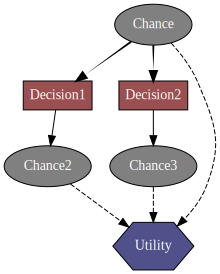

In [1]:


import os
from pylab import *
import matplotlib.pyplot as plt
from IPython.core.display import display,HTML
import math
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import numpy as np
from bandbLIMID import BranchAndBoundLIMIDInference
diag=gum.fastID("Chance->*Decision1->Chance2->$Utility<-Chance3<-*Decision2<-Chance->Utility")
gnb.showInfluenceDiagram(diag)

In [2]:
ordre=[diag.idFromName("Decision1"),diag.idFromName("Decision2")]
#ordre=[ID.idFromName("d_1"),ID.idFromName("d_0")]
bnb=BranchAndBoundLIMIDInference(diag,ordre)
d,m=bnb.branchAndBound()
print(bnb.getNameFromID(d.getNodeID()),m)
print("issue",bnb.getNameFromID(d.getIssue().getNodeID()),d.getIssue().getContexte())
print(bnb.getNamesFromID(d.getContexte().keys(),bnb.ID),d.getContexte())
print()

--------------while n° 0 taille liste, 2
{0: '0'}
{0: '1'}
début calcul evaluation de solution
changement de la solution, d'évaluation 44.89370427660928 contre None
début calcul evaluation de solution
--------------while n° 1 taille liste, 1
{0: '0'}
{0: '1'}
début calcul evaluation de solution
début calcul evaluation de solution
Decision2 44.89370427660928
issue Decision1 {0: '0'}
['Chance'] {0: '0'}



In [21]:
#gnb.showInfluenceDiagram(bnb.IDRelaxe)
hasZero=0
for nodes in bnb.IDRelaxe.nodes():
    if bnb.IDRelaxe.isChanceNode(nodes):
        if(bnb.IDRelaxe.cpt(nodes).max()==0):
            hasZero+=1
        print(bnb.getNameFromID(nodes),bnb.IDRelaxe.cpt(nodes),"MAX",bnb.IDRelaxe.cpt(nodes).max())
#d,m=bnb.branchAndBounch()


x_0 
  x_0                                                                |
0        |1        |2        |3        |4        |5        |6        |
---------|---------|---------|---------|---------|---------|---------|
 0.0000  | 0.0000  | 0.0000  | 1.0000  | 0.0000  | 0.0000  | 0.0000  |
 MAX 1.0
y_0 
      ||  y_0                                                                                    |
x_0   ||0        |1        |2        |3        |4        |5        |6        |7        |8        |
------||---------|---------|---------|---------|---------|---------|---------|---------|---------|
0     || 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  |
1     || 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  |
2     || 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  |
3     || 0.0000  | 0.0000  | 1.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  |
4   